/var/folders/_1/nf16zh8941q1hjmlsphpp8kr0000gn/T/ipykernel_62448/196111535.py:72: RuntimeWarning: invalid value encountered in divide
  train_tw_dist_true = np.divide(train_true_tw.T, train_true_tw.sum(axis=1)).T
/var/folders/_1/nf16zh8941q1hjmlsphpp8kr0000gn/T/ipykernel_62448/196111535.py:73: RuntimeWarning: invalid value encountered in divide
  train_tw_dist_pred = np.divide(train_pred_tw.T, train_pred_tw.sum(axis=1)).T
/var/folders/_1/nf16zh8941q1hjmlsphpp8kr0000gn/T/ipykernel_62448/196111535.py:46: RuntimeWarning: invalid value encountered in divide
  np.abs(level1_train_true - level1_train_pred)


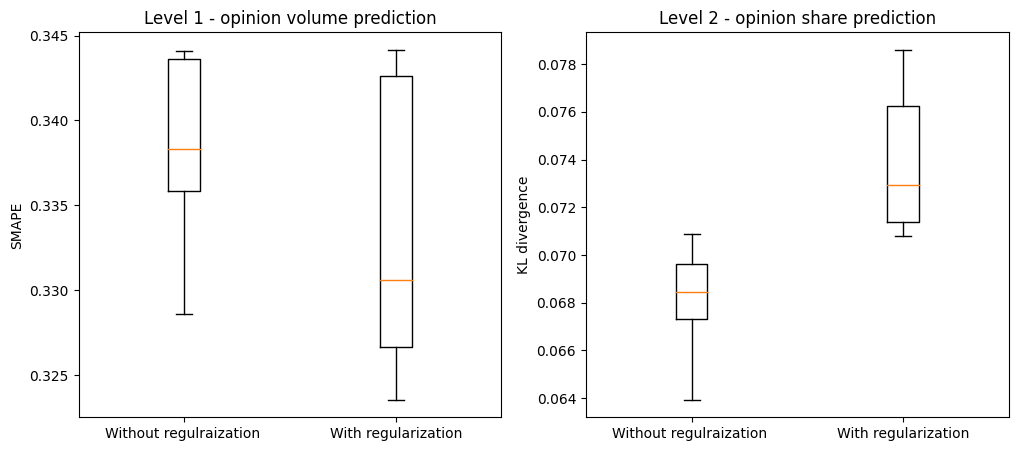

In [127]:
import pickle
import numpy as np
from scipy.stats import entropy

with open('/Users/mnurek/Projects/omm-nato/data/nato_tweets.p', 'rb') as file:
    data = pickle.load(file)

T_train = 75 * 24
T_test = 91 * 24

train_smapes = []
test_smapes = []
train_kl = []
test_kl = []

for i in range(2):
    with open(f'/Users/mnurek/Projects/omm-nato/hypertuning/T0_h_nato_reg_{i}.p', 'rb') as file:
        T0_h = pickle.load(file)

    samples = T0_h[0][0][0][3]

    train_smapes_i = []
    test_smapes_i = []

    train_kl_i = []
    test_kl_i = []

    for ns in range(5):
        # SMAPE
        train_true = data[0, :, :T_train, :]
        # train_pred = np.mean(samples[:, :T_train, :, :], axis=-1)
        train_pred = samples[:, :T_train, :, ns]

        test_true = data[0, :, T_train:T_test, :]
        # test_pred = np.mean(samples[:, T_train:T_test, :, :], axis=-1)
        test_pred = samples[:, T_train:T_test, :, ns]

        level1_train_true = np.sum(train_true, axis=-1)
        level1_train_pred = np.sum(train_pred, axis=-1)

        level1_test_true = np.sum(test_true, axis=-1)
        level1_test_pred = np.sum(test_pred, axis=-1)
        
        train_level1_smape = np.sum(
            (
                np.abs(level1_train_true - level1_train_pred)
                / (level1_train_true + level1_train_pred)
            )
            / (T_test - T_train),
            axis=1,
        )

        test_level1_smape = np.sum(
            (
                np.abs(level1_test_true - level1_test_pred)
                / (level1_test_true + level1_test_pred)
            )
            / (T_test - T_train),
            axis=1,
        )

        train_smapes_i.append(train_level1_smape)
        test_smapes_i.append(test_level1_smape)

        # KL
        train_true_tw = train_true[0, :, :]
        train_pred_tw = train_pred[0, :, :]

        test_true_tw = test_true[0, :, :]
        test_pred_tw = test_pred[0, :, :]

        train_tw_dist_true = np.divide(train_true_tw.T, train_true_tw.sum(axis=1)).T
        train_tw_dist_pred = np.divide(train_pred_tw.T, train_pred_tw.sum(axis=1)).T

        test_tw_dist_true = np.divide(test_true_tw.T, test_true_tw.sum(axis=1)).T
        test_tw_dist_pred = np.divide(test_pred_tw.T, test_pred_tw.sum(axis=1)).T

        train_tw_entropies_over_t = [
            entropy(train_tw_dist_true[i, :] + 1e-9, train_tw_dist_pred[i, :] + 1e-9)
            for i in range(train_tw_dist_pred.shape[0])
        ]

        test_tw_entropies_over_t = [
            entropy(test_tw_dist_true[i, :] + 1e-9, test_tw_dist_pred[i, :] + 1e-9)
            for i in range(test_tw_dist_pred.shape[0])
        ]

        train_level2_entropy = 1 * (
            np.array(train_tw_entropies_over_t)
        )
        test_level2_entropy = 1 * (
            np.array(test_tw_entropies_over_t)
        )

        train_tw_level2_entropy = np.nanmean(train_tw_entropies_over_t)
        test_tw_level2_entropy = np.nanmean(test_tw_entropies_over_t)

        train_kl_i.append(train_tw_level2_entropy)
        test_kl_i.append(test_tw_level2_entropy)

    train_smapes.append(train_smapes_i)
    test_smapes.append(test_smapes_i)
    train_kl.append(train_kl_i)
    test_kl.append(test_kl_i)


import matplotlib.pyplot as plt

# Remove nan values from the data
test_smapes_reg_0 = [x[0] for x in test_smapes[0] if not np.isnan(x)]
test_smapes_reg_1 = [x[0] for x in test_smapes[1] if not np.isnan(x)]

# Create a figure instance
fig, axs = plt.subplots(1,2, figsize =(12, 5))

# Create an axes instance
# ax = fig.add_subplot(111)

# Create the boxplot
axs[0].boxplot([test_smapes_reg_0, test_smapes_reg_1])
axs[0].set_xticklabels(['Without regulraization ', 'With regularization'])
axs[0].set_ylabel('SMAPE')
axs[0].set_title('Level 1 - opinion volume prediction')

axs[1].boxplot([test_kl[0], test_kl[1]])
axs[1].set_xticklabels(['Without regulraization ', 'With regularization'])
axs[1].set_ylabel('KL divergence')
axs[1].set_title('Level 2 - opinion share prediction')

plt.show()

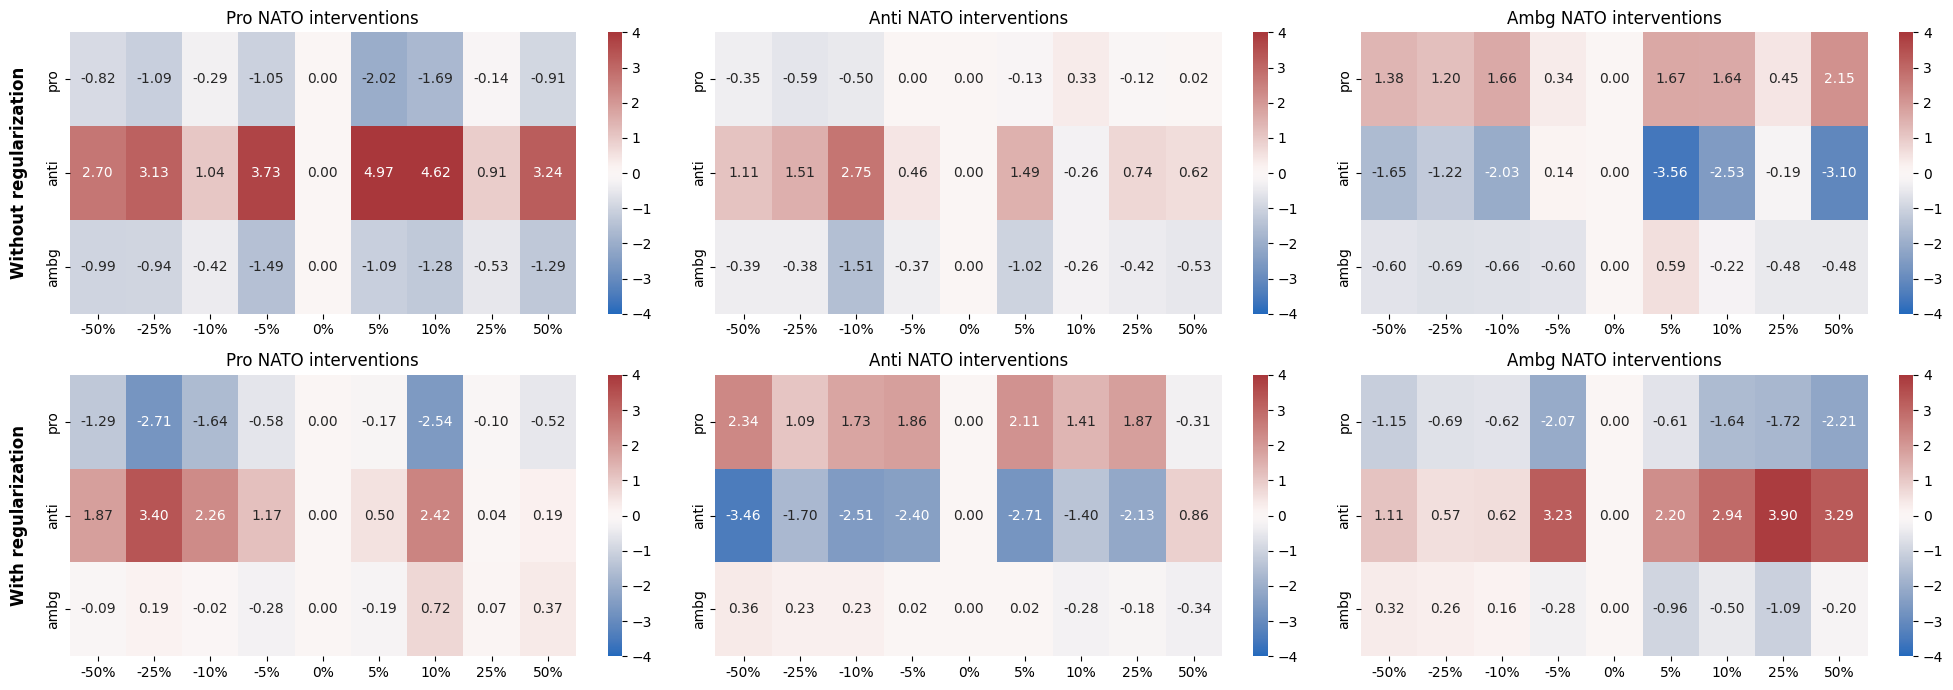

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(2,3, figsize =(20, 7), gridspec_kw={'width_ratios': [1, 1, 1]})
sns.color_palette("vlag", as_cmap=True)

row_titles = ['Without regularization', 'With regularization']
for i, ax_row in enumerate(axs):
    ax_row[0].text(-0.1, 0.5, row_titles[i], transform=ax_row[0].transAxes,
                   rotation=90, ha='center', va='center', fontsize=12, fontweight='bold')

for r in range(2):
    with open(f'/Users/mnurek/Projects/omm-nato/hypertuning/T0_h_nato_reg_{r}.p', 'rb') as file:
        T0_h = pickle.load(file)

    for x in range(3):
        interv = T0_h[0][0][0][7][x]

        interv_0 = interv[4][0]

        diffs = []

        for i in range(9):
            interv_i = interv[i][0]
            diff = (interv_i - interv_0) / interv_0 * 100

            diffs.append(diff)


        diffs = np.array(diffs)
        
        sns.heatmap(diffs.T, annot=True, fmt=".2f", cmap="vlag",
                yticklabels=['pro', 'anti', 'ambg'], xticklabels=['-50%', '-25%', '-10%', '-5%', '0%', '5%', '10%', '25%', '50%'],
                center=0, vmin=-4, vmax=4, ax=axs[r,x])
        
    axs[r,0].set_title('Pro NATO interventions')
    axs[r,1].set_title('Anti NATO interventions')
    axs[r,2].set_title('Ambg NATO interventions')


plt.tight_layout()
plt.show()

In [71]:
with open(f'/Users/mnurek/Projects/omm-nato/hypertuning/T0_h_nato_reg_{1}.p', 'rb') as file:
        data = pickle.load(file)
# 2 (from zero) - starting point
# data
# 0. sim_output_collector - array (1,)
#   0.0 num_starting_points - array (3,)
#       0.0.0 result from opinion resources_twolevel.py - array (9,)
#           0.0.0.0 xopt - array (893,)
#                0.0.0.0.0 float
#           0.0.0.1 res_opt1
#           0.0.0.2 res_opt2
#           0.0.0.3 predictions
#           0.0.0.4 fit_metrics
#           0.0.0.5 X_elasticities
#           0.0.0.6 L_elasticities
#           0.0.0.7 av_dist_on_test_over_K
#           0.0.0.8 np.all(xopt_orig == xopt)
# 1. fit_duration_collector - array (1,)
#   1.0 fit_duration - float
# data[0][0][0][8]

# 'train_lvl1_tw_smape', 'train_lvl2_tw_kl', 'test_lvl1_tw_smape', 'test_lvl2_tw_kl', 'train_kl', 'test_kl', 'train_tw_kl_over_time', 'test_tw_kl_over_time'
# len(data[0][0][0][4]['test_tw_kl_over_time'])
print(data[0][0][0][4]['test_lvl1_tw_smape'])
print(data[0][0][0][4]['test_lvl2_tw_kl'])
np.nanmean(data[0][0][0][4]['test_tw_kl_over_time'])


0.3245749260663744
0.06673228022591428


0.06673228022591428